# Tugas Besar 2 IF3270 Pembelajaran Mesin - CNN
Kelompok 36
1. Shazya Audrea Taufik - 13522063
2. Evelyn Yosiana - 13522083
3. Zahira Dina Amalia - 13522085

## Import Libraries and Setup

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
import pickle
import os
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.experimental.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.18.0
GPU Available: True


## Data Preparation

In [ ]:
def load_and_prepare_cifar10():
    # Load CIFAR-10 dataset
    (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # Normalize pixel values to [0, 1]
    x_train_full = x_train_full.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Flatten labels
    y_train_full = y_train_full.flatten()
    y_test = y_test.flatten()

    # Split training data into 4:1 ratio
    split_idx = 40000
    x_train = x_train_full[:split_idx]
    y_train = y_train_full[:split_idx]
    x_val = x_train_full[split_idx:]
    y_val = y_train_full[split_idx:]

    print(f"Training set: {x_train.shape[0]} samples")
    print(f"Validation set: {x_val.shape[0]} samples")
    print(f"Test set: {x_test.shape[0]} samples")
    print(f"Image shape: {x_train.shape[1:]}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

Training set: 40000 samples
Validation set: 10000 samples
Test set: 10000 samples
Image shape: (32, 32, 3)
Number of classes: 10


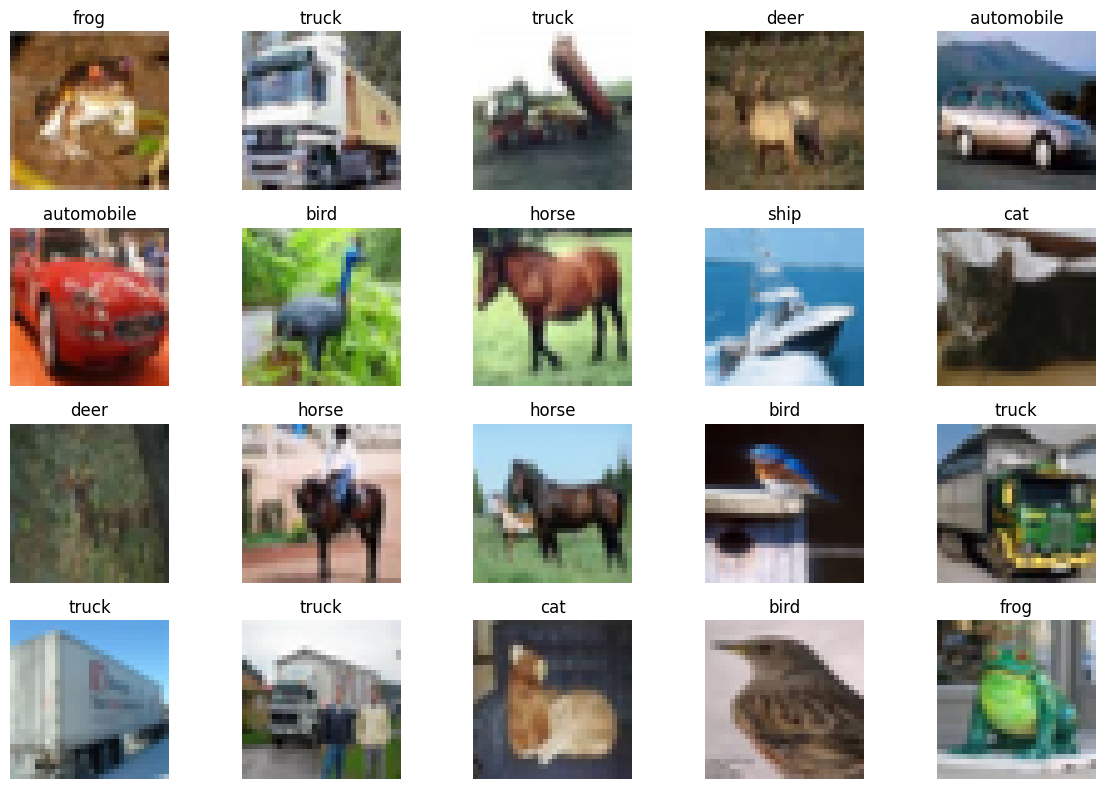

In [ ]:
# Load data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_prepare_cifar10()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize sample
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(f'{class_names[y_train[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Model

In [ ]:
def create_cnn_model(conv_layers: List[int], filters_per_layer: List[int],
                    kernel_sizes: List[int], pooling_type: str = 'max'):
    model = keras.Sequential()

    # Input layer
    model.add(layers.Input(shape=(32, 32, 3)))

    # Convolutional layers
    for i, (n_layers, n_filters, kernel_size) in enumerate(zip(conv_layers, filters_per_layer, kernel_sizes)):
        for j in range(n_layers):
            model.add(layers.Conv2D(
                filters=n_filters,
                kernel_size=kernel_size,
                activation='relu',
                padding='same',
                name=f'conv_{i}_{j}'
            ))

        # Pooling layer
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D(pool_size=(2, 2), name=f'maxpool_{i}'))
        else:
            model.add(layers.AveragePooling2D(pool_size=(2, 2), name=f'avgpool_{i}'))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', name='dense_1'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax', name='dense_output'))

    return model

In [ ]:
def train_model(model, model_name: str, epochs: int = 20):
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        x_train, y_train,
        batch_size=32,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    y_pred = model.predict(x_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    f1_macro = f1_score(y_test, y_pred_classes, average='macro')

    print(f"\n{model_name} Results:")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-Score (Macro): {f1_macro:.4f}")

    # Save model
    model.save(f'models/{model_name}.h5')

    return history, test_acc, f1_macro

In [7]:
# Create models directory
os.makedirs('models', exist_ok=True)

## Percobaan

### Percobaan 1 : Pengaruh Jumlah Layer Konvolusi

In [ ]:
print("=" * 60)
print("Percobaan 1: Pengaruh Jumlah Layer Konvolusi")
print("=" * 60)

# Variasi 1: 2 Conv layers
model_1_conv = create_cnn_model(
    conv_layers=[1, 1],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 2: 4 Conv layers
model_2_conv = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 3: 6 Conv layers
model_3_conv = create_cnn_model(
    conv_layers=[3, 3],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Train models
models_conv = [
    (model_1_conv, "2_conv_layers"),
    (model_2_conv, "4_conv_layers"),
    (model_3_conv, "6_conv_layers")
]

results_conv = {}
for model, name in models_conv:
    print(f"\nTraining {name}...")
    model.summary()
    history, test_acc, f1_macro = train_model(model, name)
    results_conv[name] = {
        'history': history,
        'test_acc': test_acc,
        'f1_macro': f1_macro
    }

Percobaan 1: Pengaruh Jumlah Layer Konvolusi

Training 2_conv_layers...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_0_0 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_0 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_0 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3216 - loss: 1.8503 - val_accuracy: 0.5599 - val_loss: 1.2687
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5187 - loss: 1.3437 - val_accuracy: 0.6165 - val_loss: 1.0938
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5801 - loss: 1.1795 - val_accuracy: 0.6411 - val_loss: 1.0070
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6200 - loss: 1.0850 - val_accuracy: 0.6589 - val_loss: 0.9713
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6401 - loss: 1.0196 - val_accuracy: 0.6700 - val_loss: 0.9426
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6627 - loss: 0.9500 - val_accuracy: 0.6774 - val_loss: 0.9253
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6813 - loss: 0.8974 - val_accuracy: 0.6830 - val_loss: 0.9163
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6951 - loss: 0.8605 


2_conv_layers Results:
Test Accuracy: 0.6942
Test F1-Score (Macro): 0.6926

Training 4_conv_layers...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_0_0 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_0 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_0 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,274 (2.26 MB)

 Trainable params: 591,274 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3031 - loss: 1.8681 - val_accuracy: 0.5361 - val_loss: 1.2843
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5134 - loss: 1.3509 - val_accuracy: 0.6243 - val_loss: 1.0675
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5823 - loss: 1.1659 - val_accuracy: 0.6622 - val_loss: 0.9490
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6332 - loss: 1.0388 - val_accuracy: 0.6818 - val_loss: 0.8958
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6671 - loss: 0.9405 - val_accuracy: 0.6867 - val_loss: 0.8945
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6880 - loss: 0.8776 - val_accuracy: 0.6927 - val_loss: 0.8762
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7202 - loss: 0.8031 - val_accuracy: 0.7081 - val_loss: 0.8364
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7324 - loss: 0.744


4_conv_layers Results:
Test Accuracy: 0.7249
Test F1-Score (Macro): 0.7254

Training 6_conv_layers...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_0_0 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_0 (MaxPooling2D)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_0 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 637,450 (2.43 MB)

 Trainable params: 637,450 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.2684 - loss: 1.9662 - val_accuracy: 0.4993 - val_loss: 1.3927
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4833 - loss: 1.4164 - val_accuracy: 0.5982 - val_loss: 1.1298
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5781 - loss: 1.1791 - val_accuracy: 0.6385 - val_loss: 1.0084
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6305 - loss: 1.0409 - val_accuracy: 0.6648 - val_loss: 0.9446
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6663 - loss: 0.9377 - val_accuracy: 0.6813 - val_loss: 0.8905
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6965 - loss: 0.8576 - val_accuracy: 0.6980 - val_loss: 0.8605
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7185 - loss: 0.7938 - val_accuracy: 0.7024 - val_loss: 0.8700
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7395 - loss: 0.730


6_conv_layers Results:
Test Accuracy: 0.7230
Test F1-Score (Macro): 0.7217


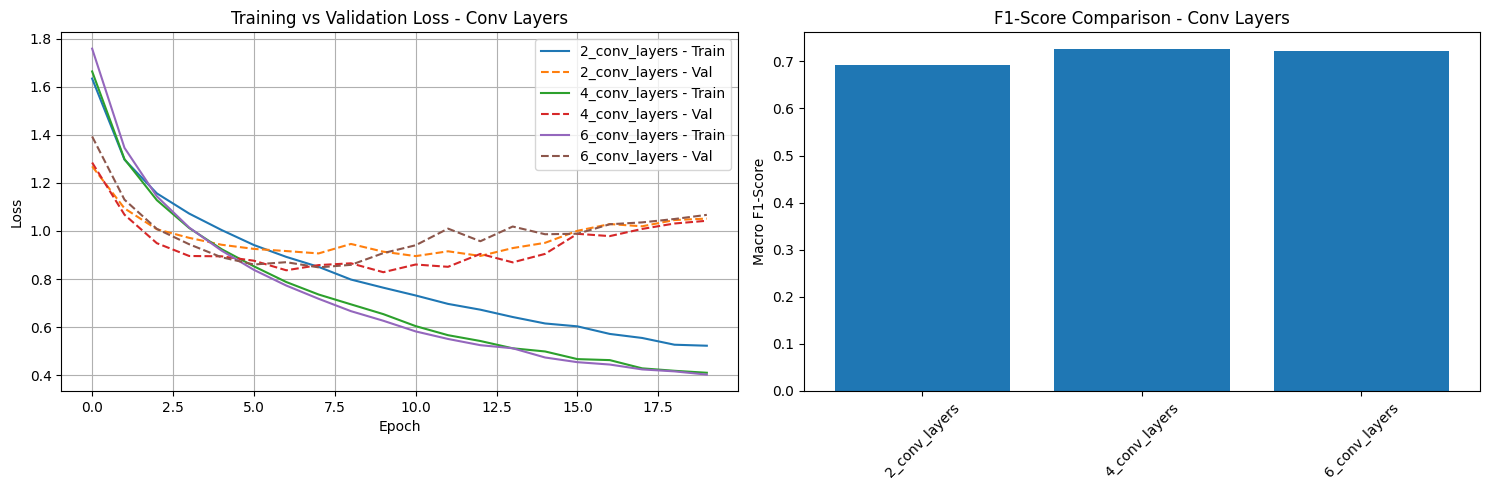

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for name, result in results_conv.items():
    history = result['history']
    axes[0].plot(history.history['loss'], label=f'{name} - Train')
    axes[0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')

axes[0].set_title('Training vs Validation Loss - Conv Layers')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

names = list(results_conv.keys())
f1_scores = [results_conv[name]['f1_macro'] for name in names]
axes[1].bar(names, f1_scores)
axes[1].set_title('F1-Score Comparison - Conv Layers')
axes[1].set_ylabel('Macro F1-Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("\nKesimpulan Percobaan 1:")
for name, result in results_conv.items():
    print(f"{name}: F1-Score = {result['f1_macro']:.4f}")


Kesimpulan Percobaan 1:
2_conv_layers: F1-Score = 0.6926
4_conv_layers: F1-Score = 0.7254
6_conv_layers: F1-Score = 0.7217


### Percobaan 2: Pengaruh Banyak Filter per Layer

In [ ]:
print("\n" + "=" * 60)
print("Percobaan 2: Pengaruh Banyak Filter per Layer")
print("=" * 60)

# Variasi 1: Sedikit filter
model_low_filters = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[16, 32],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 2: Sedang filter
model_med_filters = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 3: Banyak filter
model_high_filters = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[64, 128],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

models_filters = [
    (model_low_filters, "low_filters_16_32"),
    (model_med_filters, "med_filters_32_64"),
    (model_high_filters, "high_filters_64_128")
]

results_filters = {}
for model, name in models_filters:
    print(f"\nTraining {name}...")
    history, test_acc, f1_macro = train_model(model, name)
    results_filters[name] = {
        'history': history,
        'test_acc': test_acc,
        'f1_macro': f1_macro
    }


Percobaan 2: Pengaruh Banyak Filter per Layer

Training low_filters_16_32...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3118 - loss: 1.8511 - val_accuracy: 0.5327 - val_loss: 1.3030
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5213 - loss: 1.3338 - val_accuracy: 0.6154 - val_loss: 1.0927
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5953 - loss: 1.1427 - val_accuracy: 0.6417 - val_loss: 1.0166
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6374 - loss: 1.0273 - val_accuracy: 0.6597 - val_loss: 0.9536
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6608 - loss: 0.9563 - val_accuracy: 0.6793 - val_loss: 0.9108
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6829 - loss: 0.8869 - val_accuracy: 0.6883 - val_loss: 0.8887
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7033 - loss: 0.8343 - val_accuracy: 0.7006 - val_loss: 0.8603
Epoch 8/2


low_filters_16_32 Results:
Test Accuracy: 0.6913
Test F1-Score (Macro): 0.6876

Training med_filters_32_64...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3061 - loss: 1.8730 - val_accuracy: 0.5670 - val_loss: 1.2163
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5387 - loss: 1.2828 - val_accuracy: 0.6408 - val_loss: 0.9984
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6190 - loss: 1.0741 - val_accuracy: 0.6825 - val_loss: 0.9035
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6643 - loss: 0.9425 - val_accuracy: 0.6885 - val_loss: 0.8926
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6999 - loss: 0.8488 - val_accuracy: 0.7098 - val_loss: 0.8321
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7243 - loss: 0.7822 - val_accuracy: 0.7269 - val_loss: 0.7912
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7444 - loss: 0.7177 - val_accuracy: 


med_filters_32_64 Results:
Test Accuracy: 0.7354
Test F1-Score (Macro): 0.7364

Training high_filters_64_128...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.2888 - loss: 1.8997 - val_accuracy: 0.5458 - val_loss: 1.2421
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5262 - loss: 1.3182 - val_accuracy: 0.6391 - val_loss: 1.0116
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6029 - loss: 1.1120 - val_accuracy: 0.6638 - val_loss: 0.9360
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6505 - loss: 0.9866 - val_accuracy: 0.6966 - val_loss: 0.8575
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6891 - loss: 0.8846 - val_accuracy: 0.7115 - val_loss: 0.8201
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7174 - loss: 0.7934 - val_accuracy: 0.7292 - val_loss: 0.7833
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7397 - loss: 0.7378 - val_accuracy: 


high_filters_64_128 Results:
Test Accuracy: 0.7364
Test F1-Score (Macro): 0.7363


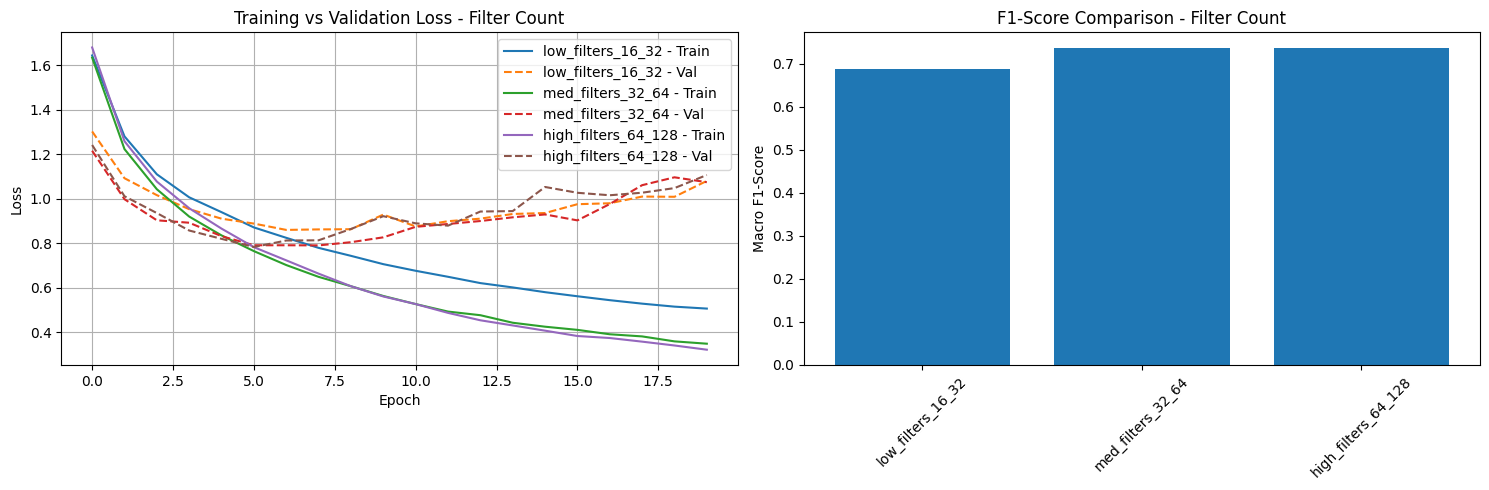

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for name, result in results_filters.items():
    history = result['history']
    axes[0].plot(history.history['loss'], label=f'{name} - Train')
    axes[0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')

axes[0].set_title('Training vs Validation Loss - Filter Count')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

names = list(results_filters.keys())
f1_scores = [results_filters[name]['f1_macro'] for name in names]
axes[1].bar(names, f1_scores)
axes[1].set_title('F1-Score Comparison - Filter Count')
axes[1].set_ylabel('Macro F1-Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("\nKesimpulan Percobaan 2:")
for name, result in results_filters.items():
    print(f"{name}: F1-Score = {result['f1_macro']:.4f}")


Kesimpulan Percobaan 2:
low_filters_16_32: F1-Score = 0.6876
med_filters_32_64: F1-Score = 0.7364
high_filters_64_128: F1-Score = 0.7363


### Percobaan 3: Pengaruh Ukuran Filter per Layer

In [ ]:
print("\n" + "=" * 60)
print("Percobaan 3: Pengaruh Ukuran Filter per Layer")
print("=" * 60)

# Variasi 1: Filter kecil (3x3)
model_small_kernel = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 2: Filter sedang (5x5)
model_med_kernel = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[5, 5],
    pooling_type='max'
)

# Variasi 3: Filter besar (7x7)
model_large_kernel = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[7, 7],
    pooling_type='max'
)

models_kernels = [
    (model_small_kernel, "kernel_3x3"),
    (model_med_kernel, "kernel_5x5"),
    (model_large_kernel, "kernel_7x7")
]

results_kernels = {}
for model, name in models_kernels:
    print(f"\nTraining {name}...")
    history, test_acc, f1_macro = train_model(model, name)
    results_kernels[name] = {
        'history': history,
        'test_acc': test_acc,
        'f1_macro': f1_macro
    }


Percobaan 3: Pengaruh Ukuran Filter per Layer

Training kernel_3x3...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2839 - loss: 1.9165 - val_accuracy: 0.5251 - val_loss: 1.2994
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5282 - loss: 1.3072 - val_accuracy: 0.6314 - val_loss: 1.0275
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6186 - loss: 1.0704 - val_accuracy: 0.6745 - val_loss: 0.9108
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6640 - loss: 0.9463 - val_accuracy: 0.6942 - val_loss: 0.8642
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6996 - loss: 0.8504 - val_accuracy: 0.7172 - val_loss: 0.8017
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7278 - loss: 0.7737 - val_accuracy: 0.7247 - val_loss: 0.7973
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7453 - loss: 0.7159 - val_accuracy: 0.7292 - val_loss: 0.8023
Epoch 8/20
1250


kernel_3x3 Results:
Test Accuracy: 0.7240
Test F1-Score (Macro): 0.7218

Training kernel_5x5...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2679 - loss: 1.9445 - val_accuracy: 0.4836 - val_loss: 1.4065
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4846 - loss: 1.4214 - val_accuracy: 0.5740 - val_loss: 1.1743
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5735 - loss: 1.2038 - val_accuracy: 0.6271 - val_loss: 1.0506
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6288 - loss: 1.0574 - val_accuracy: 0.6634 - val_loss: 0.9663
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6704 - loss: 0.9399 - val_accuracy: 0.6802 - val_loss: 0.9263
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6993 - loss: 0.8547 - val_accuracy: 0.6829 - val_loss: 0.9612
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7188 - loss: 0.7833 - val_accuracy: 0.6917 - val_l


kernel_5x5 Results:
Test Accuracy: 0.6923
Test F1-Score (Macro): 0.6904

Training kernel_7x7...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2310 - loss: 2.0272 - val_accuracy: 0.4463 - val_loss: 1.5053
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4277 - loss: 1.5623 - val_accuracy: 0.5100 - val_loss: 1.3623
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5027 - loss: 1.3874 - val_accuracy: 0.5647 - val_loss: 1.2245
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5529 - loss: 1.2553 - val_accuracy: 0.5837 - val_loss: 1.1769
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5934 - loss: 1.1474 - val_accuracy: 0.6054 - val_loss: 1.1343
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6205 - loss: 1.0579 - val_accuracy: 0.6031 - val_loss: 1.1544
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.6537 - loss: 0.9811 - val_accuracy: 0.623


kernel_7x7 Results:
Test Accuracy: 0.6147
Test F1-Score (Macro): 0.6127


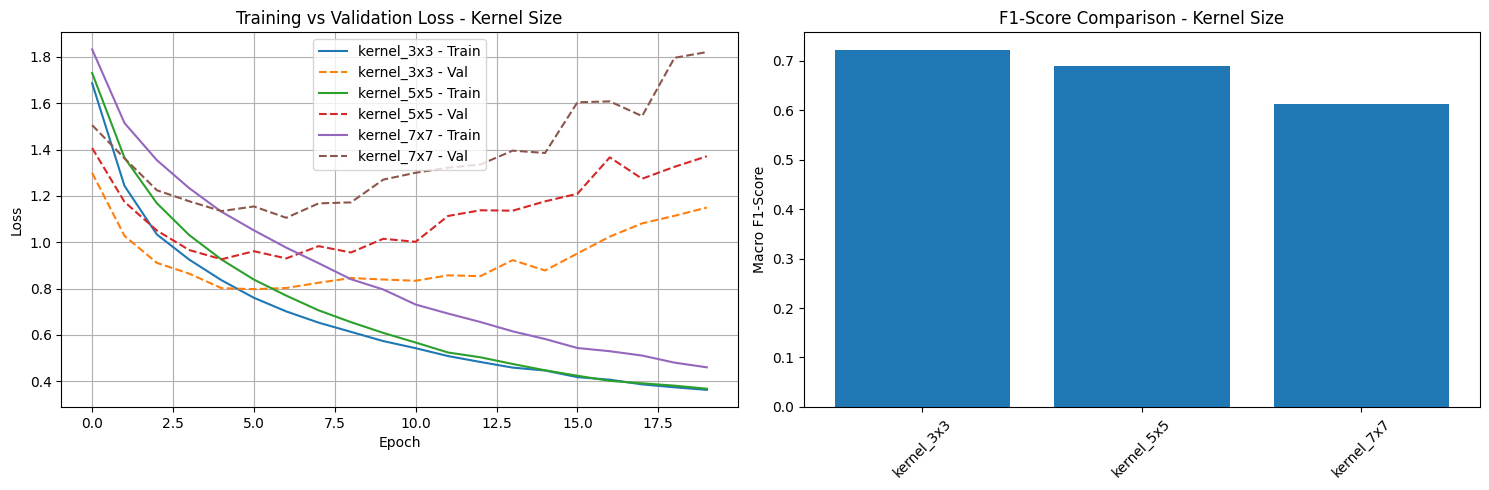

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for name, result in results_kernels.items():
    history = result['history']
    axes[0].plot(history.history['loss'], label=f'{name} - Train')
    axes[0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')

axes[0].set_title('Training vs Validation Loss - Kernel Size')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

names = list(results_kernels.keys())
f1_scores = [results_kernels[name]['f1_macro'] for name in names]
axes[1].bar(names, f1_scores)
axes[1].set_title('F1-Score Comparison - Kernel Size')
axes[1].set_ylabel('Macro F1-Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [23]:
print("\nKesimpulan Percobaan 3:")
for name, result in results_kernels.items():
    print(f"{name}: F1-Score = {result['f1_macro']:.4f}")


Kesimpulan Percobaan 3:
kernel_3x3: F1-Score = 0.7218
kernel_5x5: F1-Score = 0.6904
kernel_7x7: F1-Score = 0.6127


### Percobaan 4: Pengaruh Jenis Pooling Layer

In [24]:
print("\n" + "=" * 60)
print("Percobaan 4: Pengaruh Jenis Pooling Layer")
print("=" * 60)

# Variasi 1: Max Pooling
model_max_pool = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='max'
)

# Variasi 2: Average Pooling
model_avg_pool = create_cnn_model(
    conv_layers=[2, 2],
    filters_per_layer=[32, 64],
    kernel_sizes=[3, 3],
    pooling_type='average'
)

models_pooling = [
    (model_max_pool, "max_pooling"),
    (model_avg_pool, "average_pooling")
]

results_pooling = {}
for model, name in models_pooling:
    print(f"\nTraining {name}...")
    history, test_acc, f1_macro = train_model(model, name)
    results_pooling[name] = {
        'history': history,
        'test_acc': test_acc,
        'f1_macro': f1_macro
    }


Percobaan 4: Pengaruh Jenis Pooling Layer

Training max_pooling...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2953 - loss: 1.9038 - val_accuracy: 0.5353 - val_loss: 1.2966
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5163 - loss: 1.3423 - val_accuracy: 0.6223 - val_loss: 1.0494
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5946 - loss: 1.1414 - val_accuracy: 0.6680 - val_loss: 0.9403
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6480 - loss: 1.0048 - val_accuracy: 0.6855 - val_loss: 0.8920
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6761 - loss: 0.9135 - val_accuracy: 0.7084 - val_loss: 0.8293
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7020 - loss: 0.8295 - val_accuracy: 0.7246 - val_loss: 0.7956
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7236 - loss: 0.7739 - val_accuracy: 0.7282 - val_loss: 0.7891
Epoch 8/20
1250/1250


max_pooling Results:
Test Accuracy: 0.7327
Test F1-Score (Macro): 0.7306

Training average_pooling...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2970 - loss: 1.8955 - val_accuracy: 0.5447 - val_loss: 1.2708
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5227 - loss: 1.3266 - val_accuracy: 0.6357 - val_loss: 1.0330
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6033 - loss: 1.1198 - val_accuracy: 0.6691 - val_loss: 0.9445
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6473 - loss: 0.9909 - val_accuracy: 0.6989 - val_loss: 0.8451
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6853 - loss: 0.8841 - val_accuracy: 0.7106 - val_loss: 0.8190
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7143 - loss: 0.8025 - val_accuracy: 0.7318 - val_loss: 0.7743
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7411 - loss: 0.7327 - val_accuracy: 0.7344 - va


average_pooling Results:
Test Accuracy: 0.7473
Test F1-Score (Macro): 0.7439


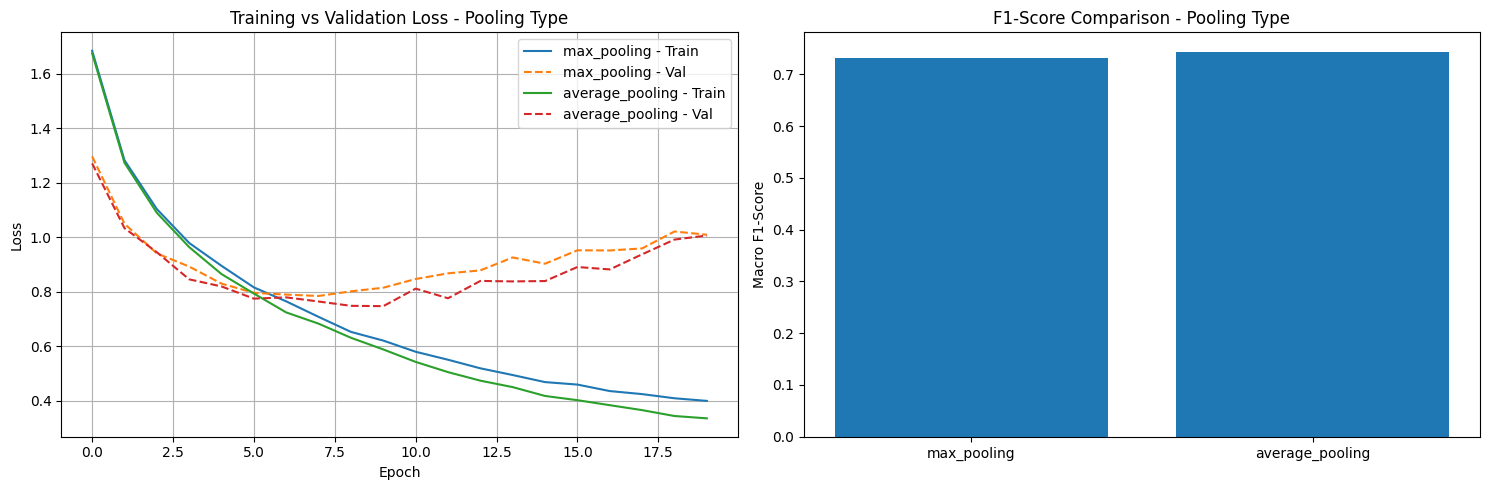

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for name, result in results_pooling.items():
    history = result['history']
    axes[0].plot(history.history['loss'], label=f'{name} - Train')
    axes[0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')

axes[0].set_title('Training vs Validation Loss - Pooling Type')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

names = list(results_pooling.keys())
f1_scores = [results_pooling[name]['f1_macro'] for name in names]
axes[1].bar(names, f1_scores)
axes[1].set_title('F1-Score Comparison - Pooling Type')
axes[1].set_ylabel('Macro F1-Score')

plt.tight_layout()
plt.show()

In [26]:
print("\nKesimpulan Percobaan 4:")
for name, result in results_pooling.items():
    print(f"{name}: F1-Score = {result['f1_macro']:.4f}")


Kesimpulan Percobaan 4:
max_pooling: F1-Score = 0.7306
average_pooling: F1-Score = 0.7439


## Model From Scratch

In [2]:
class Conv2DLayer:
    def __init__(self, weights, bias, activation='relu', padding='same'):
        self.weights = weights  # Shape: (kernel_h, kernel_w, input_channels, output_channels)
        self.bias = bias        # Shape: (output_channels,)
        self.activation = activation
        self.padding = padding

    def forward(self, x):
        batch_size, input_h, input_w, input_channels = x.shape
        kernel_h, kernel_w, _, output_channels = self.weights.shape

        # Calculate output dimensions
        if self.padding == 'same':
            output_h = input_h
            output_w = input_w
            pad_h = max(0, (kernel_h - 1) // 2)
            pad_w = max(0, (kernel_w - 1) // 2)
        else:  # 'valid'
            output_h = input_h - kernel_h + 1
            output_w = input_w - kernel_w + 1
            pad_h = pad_w = 0

        # Pad input
        if self.padding == 'same':
            x_padded = np.pad(x, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
        else:
            x_padded = x

        # Initialize output
        output = np.zeros((batch_size, output_h, output_w, output_channels))

        # Perform convolution
        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(output_channels):
                        # Extract patch
                        patch = x_padded[b, h:h+kernel_h, w:w+kernel_w, :]
                        # Convolution operation
                        output[b, h, w, c] = np.sum(patch * self.weights[:, :, :, c]) + self.bias[c]

        # Apply activation
        if self.activation == 'relu':
            output = np.maximum(0, output)

        return output

class MaxPooling2DLayer:
    def __init__(self, pool_size=(2, 2)):
        self.pool_size = pool_size

    def forward(self, x):
        batch_size, input_h, input_w, channels = x.shape
        pool_h, pool_w = self.pool_size

        output_h = input_h // pool_h
        output_w = input_w // pool_w

        output = np.zeros((batch_size, output_h, output_w, channels))

        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(channels):
                        patch = x[b, h*pool_h:(h+1)*pool_h, w*pool_w:(w+1)*pool_w, c]
                        output[b, h, w, c] = np.max(patch)

        return output

class AveragePooling2DLayer:
    def __init__(self, pool_size=(2, 2)):
        self.pool_size = pool_size

    def forward(self, x):
        batch_size, input_h, input_w, channels = x.shape
        pool_h, pool_w = self.pool_size

        output_h = input_h // pool_h
        output_w = input_w // pool_w

        output = np.zeros((batch_size, output_h, output_w, channels))

        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(channels):
                        patch = x[b, h*pool_h:(h+1)*pool_h, w*pool_w:(w+1)*pool_w, c]
                        output[b, h, w, c] = np.mean(patch)

        return output

class FlattenLayer:
    def forward(self, x):
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1)

class DenseLayer:
    def __init__(self, weights, bias, activation=None):
        self.weights = weights  # Shape: (input_dim, output_dim)
        self.bias = bias        # Shape: (output_dim,)
        self.activation = activation

    def forward(self, x):
        output = np.dot(x, self.weights) + self.bias

        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'softmax':
            exp_scores = np.exp(output - np.max(output, axis=1, keepdims=True))
            output = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return output

class CNNFromScratch:
    def __init__(self, keras_model):
        # Initialize CNN from Keras model weights
        self.layers = []
        self._build_from_keras(keras_model)

    def _build_from_keras(self, keras_model):
        # Build CNN layers from Keras model
        for layer in keras_model.layers:
            if isinstance(layer, keras.layers.Conv2D):
                weights, bias = layer.get_weights()
                self.layers.append(Conv2DLayer(weights, bias, 'relu', layer.padding))

            elif isinstance(layer, keras.layers.MaxPooling2D):
                self.layers.append(MaxPooling2DLayer(layer.pool_size))

            elif isinstance(layer, keras.layers.AveragePooling2D):
                self.layers.append(AveragePooling2DLayer(layer.pool_size))

            elif isinstance(layer, keras.layers.Flatten):
                self.layers.append(FlattenLayer())

            elif isinstance(layer, keras.layers.Dense):
                weights, bias = layer.get_weights()
                activation = None
                if layer.activation.__name__ == 'relu':
                    activation = 'relu'
                elif layer.activation.__name__ == 'softmax':
                    activation = 'softmax'
                self.layers.append(DenseLayer(weights, bias, activation))

            elif isinstance(layer, keras.layers.Dropout):
                # Skip dropout in inference
                continue

    def predict(self, x, batch_size=32):
        n_samples = x.shape[0]
        predictions = []

        for i in range(0, n_samples, batch_size):
            batch_end = min(i + batch_size, n_samples)
            batch_x = x[i:batch_end]

            # Forward pass through all layers
            current_input = batch_x
            for layer in self.layers:
                current_input = layer.forward(current_input)

            predictions.append(current_input)

        return np.vstack(predictions)

## Forward Propagation Testing

In [30]:
print("\n" + "=" * 60)
print("TESTING FORWARD PROPAGATION IMPLEMENTATION")
print("=" * 60)

best_model = keras.models.load_model('models/med_filters_32_64.h5')

custom_cnn = CNNFromScratch(best_model)

# Test on a small subset first
test_batch_size = 100
x_test_small = x_test[:test_batch_size]
y_test_small = y_test[:test_batch_size]

print(f"Testing on {test_batch_size} samples...")

# Keras predictions
keras_predictions = best_model.predict(x_test_small, verbose=0)
keras_classes = np.argmax(keras_predictions, axis=1)

# Custom implementation predictions
custom_predictions = custom_cnn.predict(x_test_small, batch_size=32)
custom_classes = np.argmax(custom_predictions, axis=1)

# Compare predictions
print(f"Keras predictions shape: {keras_predictions.shape}")
print(f"Custom predictions shape: {custom_predictions.shape}")

predictions_close = np.allclose(keras_predictions, custom_predictions, rtol=1e-4, atol=1e-4)
print(f"Predictions are close: {predictions_close}")

# Calculate differences
max_diff = np.max(np.abs(keras_predictions - custom_predictions))
mean_diff = np.mean(np.abs(keras_predictions - custom_predictions))
print(f"Maximum difference: {max_diff:.6f}")
print(f"Mean difference: {mean_diff:.6f}")

# Compare class predictions
same_predictions = np.sum(keras_classes == custom_classes)
print(f"Same class predictions: {same_predictions}/{test_batch_size} ({100*same_predictions/test_batch_size:.1f}%)")

# Calculate F1 scores
keras_f1 = f1_score(y_test_small, keras_classes, average='macro')
custom_f1 = f1_score(y_test_small, custom_classes, average='macro')

print(f"Keras F1-Score: {keras_f1:.4f}")
print(f"Custom F1-Score: {custom_f1:.4f}")
print(f"F1-Score difference: {abs(keras_f1 - custom_f1):.4f}")


TESTING FORWARD PROPAGATION IMPLEMENTATION
Testing on 100 samples...
Keras predictions shape: (100, 10)
Custom predictions shape: (100, 10)
Predictions are close: True
Maximum difference: 0.000001
Mean difference: 0.000000
Same class predictions: 100/100 (100.0%)
Keras F1-Score: 0.7629
Custom F1-Score: 0.7629
F1-Score difference: 0.0000


## Test Set Evaluation

In [31]:
print("\n" + "=" * 60)
print("FULL TEST SET EVALUATION")
print("=" * 60)

# Keras predictions on full test set
keras_predictions_full = best_model.predict(x_test, batch_size=32, verbose=1)
keras_classes_full = np.argmax(keras_predictions_full, axis=1)

# Custom implementation predictions on full test set
print("Running custom implementation...")
custom_predictions_full = custom_cnn.predict(x_test, batch_size=32)
custom_classes_full = np.argmax(custom_predictions_full, axis=1)

# Calculate F1 scores
keras_f1_full = f1_score(y_test, keras_classes_full, average='macro')
custom_f1_full = f1_score(y_test, custom_classes_full, average='macro')

print(f"\nFinal Results on Test Set:")
print(f"Keras F1-Score: {keras_f1_full:.4f}")
print(f"Custom Implementation F1-Score: {custom_f1_full:.4f}")
print(f"F1-Score difference: {abs(keras_f1_full - custom_f1_full):.4f}")

# Detailed classification report
print("\nKeras Classification Report:")
print(classification_report(y_test, keras_classes_full, target_names=class_names))

print("\nCustom Implementation Classification Report:")
print(classification_report(y_test, custom_classes_full, target_names=class_names))


FULL TEST SET EVALUATION
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running custom implementation...

Final Results on Test Set:
Keras F1-Score: 0.7364
Custom Implementation F1-Score: 0.7364
F1-Score difference: 0.0000

Keras Classification Report:
              precision    recall  f1-score   support

    airplane       0.76      0.80      0.78      1000
  automobile       0.86      0.89      0.87      1000
        bird       0.63      0.61      0.62      1000
         cat       0.50      0.56      0.53      1000
        deer       0.71      0.65      0.68      1000
         dog       0.65      0.64      0.64      1000
        frog       0.81      0.74      0.78      1000
       horse       0.75      0.82      0.78      1000
        ship       0.88      0.81      0.84      1000
       truck       0.84      0.83      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     

## CNN with Backpropagation

In [3]:
class Conv2DLayerWithBackprop(Conv2DLayer):
    def __init__(self, weights, bias, activation='relu', padding='same'):
        super().__init__(weights, bias, activation, padding)
        self.last_input = None
        self.last_output = None

    def forward(self, x):
        self.last_input = x
        output = super().forward(x)
        self.last_output = output
        return output

    def backward(self, grad_output):
        batch_size, input_h, input_w, input_channels = self.last_input.shape
        kernel_h, kernel_w, _, output_channels = self.weights.shape

        # Apply activation derivative
        if self.activation == 'relu':
            grad_output = grad_output * (self.last_output > 0)

        # Initialize gradients
        grad_weights = np.zeros_like(self.weights)
        grad_bias = np.zeros_like(self.bias)
        grad_input = np.zeros_like(self.last_input)

        # Calculate padding
        if self.padding == 'same':
            pad_h = max(0, (kernel_h - 1) // 2)
            pad_w = max(0, (kernel_w - 1) // 2)
            x_padded = np.pad(self.last_input, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
        else:
            pad_h = pad_w = 0
            x_padded = self.last_input

        output_h, output_w = grad_output.shape[1:3]

        # Calculate gradients
        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(output_channels):
                        # Gradient w.r.t. weights
                        patch = x_padded[b, h:h+kernel_h, w:w+kernel_w, :]
                        grad_weights[:, :, :, c] += patch * grad_output[b, h, w, c]

                        # Gradient w.r.t. bias
                        grad_bias[c] += grad_output[b, h, w, c]

                        # Gradient w.r.t. input
                        if pad_h > 0 or pad_w > 0:
                            start_h = max(0, h - pad_h)
                            end_h = min(input_h, h + kernel_h - pad_h)
                            start_w = max(0, w - pad_w)
                            end_w = min(input_w, w + kernel_w - pad_w)

                            kernel_start_h = max(0, pad_h - h)
                            kernel_end_h = kernel_start_h + (end_h - start_h)
                            kernel_start_w = max(0, pad_w - w)
                            kernel_end_w = kernel_start_w + (end_w - start_w)

                            grad_input[b, start_h:end_h, start_w:end_w, :] += \
                                self.weights[kernel_start_h:kernel_end_h, kernel_start_w:kernel_end_w, :, c] * grad_output[b, h, w, c]
                        else:
                            grad_input[b, h:h+kernel_h, w:w+kernel_w, :] += \
                                self.weights[:, :, :, c] * grad_output[b, h, w, c]

        return grad_input, grad_weights, grad_bias

class DenseLayerWithBackprop(DenseLayer):
    def __init__(self, weights, bias, activation=None):
        super().__init__(weights, bias, activation)
        self.last_input = None
        self.last_output = None

    def forward(self, x):
        self.last_input = x
        output = super().forward(x)
        self.last_output = output
        return output

    def backward(self, grad_output):
        # Apply activation derivative
        if self.activation == 'relu':
            grad_output = grad_output * (self.last_output > 0)
        elif self.activation == 'softmax':
            # For softmax, gradient is handled in loss function
            pass

        # Calculate gradients
        grad_weights = np.dot(self.last_input.T, grad_output)
        grad_bias = np.sum(grad_output, axis=0)
        grad_input = np.dot(grad_output, self.weights.T)

        return grad_input, grad_weights, grad_bias

class MaxPooling2DLayerWithBackprop(MaxPooling2DLayer):
    def __init__(self, pool_size=(2, 2)):
        super().__init__(pool_size)
        self.last_input = None
        self.max_indices = None

    def forward(self, x):
        self.last_input = x
        batch_size, input_h, input_w, channels = x.shape
        pool_h, pool_w = self.pool_size

        output_h = input_h // pool_h
        output_w = input_w // pool_w

        output = np.zeros((batch_size, output_h, output_w, channels))
        self.max_indices = np.zeros((batch_size, output_h, output_w, channels, 2), dtype=int)

        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(channels):
                        patch = x[b, h*pool_h:(h+1)*pool_h, w*pool_w:(w+1)*pool_w, c]
                        max_idx = np.unravel_index(np.argmax(patch), patch.shape)
                        output[b, h, w, c] = patch[max_idx]
                        self.max_indices[b, h, w, c, :] = [h*pool_h + max_idx[0], w*pool_w + max_idx[1]]

        return output

    def backward(self, grad_output):
        batch_size, input_h, input_w, channels = self.last_input.shape
        grad_input = np.zeros_like(self.last_input)

        output_h, output_w = grad_output.shape[1:3]

        for b in range(batch_size):
            for h in range(output_h):
                for w in range(output_w):
                    for c in range(channels):
                        max_h, max_w = self.max_indices[b, h, w, c, :]
                        grad_input[b, max_h, max_w, c] += grad_output[b, h, w, c]

        return grad_input

class CNNFromScratchWithBackprop:
    def __init__(self, keras_model):
        self.layers = []
        self._build_from_keras(keras_model)

    def _build_from_keras(self, keras_model):
        for layer in keras_model.layers:
            if isinstance(layer, keras.layers.Conv2D):
                weights, bias = layer.get_weights()
                self.layers.append(Conv2DLayerWithBackprop(weights, bias, 'relu', layer.padding))

            elif isinstance(layer, keras.layers.MaxPooling2D):
                self.layers.append(MaxPooling2DLayerWithBackprop(layer.pool_size))

            elif isinstance(layer, keras.layers.AveragePooling2D):
                self.layers.append(AveragePooling2DLayerWithBackprop(layer.pool_size))

            elif isinstance(layer, keras.layers.Flatten):
                self.layers.append(FlattenLayer())

            elif isinstance(layer, keras.layers.Dense):
                weights, bias = layer.get_weights()
                activation = None
                if layer.activation.__name__ == 'relu':
                    activation = 'relu'
                elif layer.activation.__name__ == 'softmax':
                    activation = 'softmax'
                self.layers.append(DenseLayerWithBackprop(weights, bias, activation))

            elif isinstance(layer, keras.layers.Dropout):
                # Skip dropout in inference
                continue

    def predict(self, x, batch_size=32):
        n_samples = x.shape[0]
        predictions = []

        for i in range(0, n_samples, batch_size):
            batch_end = min(i + batch_size, n_samples)
            batch_x = x[i:batch_end]

            # Forward pass through all layers
            current_input = batch_x
            for layer in self.layers:
                current_input = layer.forward(current_input)

            predictions.append(current_input)

        return np.vstack(predictions)

    def forward_with_cache(self, x):
        activations = [x]
        current_input = x

        for layer in self.layers:
            current_input = layer.forward(current_input)
            activations.append(current_input)

        return current_input, activations

    def backward(self, grad_output, activations):
        gradients = []
        current_grad = grad_output

        # Go through layers in reverse order
        for i, layer in enumerate(reversed(self.layers)):
            layer_idx = len(self.layers) - 1 - i

            if isinstance(layer, (Conv2DLayerWithBackprop, DenseLayerWithBackprop)):
                grad_input, grad_weights, grad_bias = layer.backward(current_grad)
                gradients.insert(0, (grad_weights, grad_bias))
                current_grad = grad_input
            elif isinstance(layer, MaxPooling2DLayerWithBackprop):
                current_grad = layer.backward(current_grad)
                gradients.insert(0, None)  # No parameters to update
            elif isinstance(layer, FlattenLayer):
                # Reshape gradient to match the input of flatten layer
                original_shape = activations[layer_idx].shape
                current_grad = current_grad.reshape(original_shape)
                gradients.insert(0, None)  # No parameters to update

        return gradients


In [39]:
# Example of how to use the custom CNN implementation
example_input = x_test[:5]  # 5 test samples
print(f"Example input shape: {example_input.shape}")

# Load any saved model
example_model = keras.models.load_model(f'models/med_filters_32_64.h5')
example_custom_cnn = CNNFromScratch(example_model)

# Make predictions
keras_pred = example_model.predict(example_input, verbose=0)
custom_pred = example_custom_cnn.predict(example_input, batch_size=5)

print(f"Keras predictions shape: {keras_pred.shape}")
print(f"Custom predictions shape: {custom_pred.shape}")
print(f"Predictions match: {np.allclose(keras_pred, custom_pred, rtol=1e-4)}")

# Show predicted classes
keras_classes = np.argmax(keras_pred, axis=1)
custom_classes = np.argmax(custom_pred, axis=1)
actual_classes = y_test[:5]

print(f"\nPrediction comparison:")
print(f"Actual:  {actual_classes}")
print(f"Keras:   {keras_classes}")
print(f"Custom:  {custom_classes}")

for i in range(5):
    print(f"Sample {i}: {class_names[actual_classes[i]]} | "
          f"Keras: {class_names[keras_classes[i]]} | "
          f"Custom: {class_names[custom_classes[i]]}")

Example input shape: (5, 32, 32, 3)
Keras predictions shape: (5, 10)
Custom predictions shape: (5, 10)
Predictions match: True

Prediction comparison:
Actual:  [3 8 8 0 6]
Keras:   [3 8 0 1 6]
Custom:  [3 8 0 1 6]
Sample 0: cat | Keras: cat | Custom: cat
Sample 1: ship | Keras: ship | Custom: ship
Sample 2: ship | Keras: airplane | Custom: airplane
Sample 3: airplane | Keras: automobile | Custom: automobile
Sample 4: frog | Keras: frog | Custom: frog


In [40]:
print(f"\n" + "=" * 80)
print("BACKWARD PROPAGATION IMPLEMENTATION TESTING")
print("=" * 80)

def test_backprop_implementation():
    print("Testing backward propagation implementation...")

    # Use the same best model from forward propagation testing
    try:
        best_model_name = 'med_filters_32_64'
        if 'best_model' in locals() or 'best_model' in globals():
            test_model = best_model
            model_name = best_model_name if 'best_model_name' in locals() else "loaded_model"
        else:
            test_model = create_cnn_model(
                conv_layers=[1, 1],
                filters_per_layer=[16, 32],
                kernel_sizes=[3, 3],
                pooling_type='max'
            )
            print("Training simple model for backprop testing...")
            _, _, _ = train_model(test_model, 'backprop_test_model', epochs=3)
            model_name = "backprop_test_model"
    except:
        # Fallback model
        test_model = create_cnn_model(
            conv_layers=[1, 1],
            filters_per_layer=[8, 16],
            kernel_sizes=[3, 3],
            pooling_type='max'
        )
        print("Training fallback model for backprop testing...")
        _, _, _ = train_model(test_model, 'fallback_backprop_model', epochs=2)
        model_name = "fallback_backprop_model"

    print(f"Using model: {model_name}")

    custom_cnn_backprop = CNNFromScratchWithBackprop(test_model)

    # Test on small subset
    test_batch_size = 50
    x_test_small = x_test[:test_batch_size]
    y_test_small = y_test[:test_batch_size]

    print(f"\nTesting backward propagation on {test_batch_size} samples...")

    # Forward pass with custom implementation
    print("Running forward pass with custom backprop implementation...")
    custom_predictions, activations = custom_cnn_backprop.forward_with_cache(x_test_small)
    custom_classes = np.argmax(custom_predictions, axis=1)

    # Compare with Keras forward pass
    keras_predictions = test_model.predict(x_test_small, verbose=0)
    keras_classes = np.argmax(keras_predictions, axis=1)

    print(f"\nFORWARD PASS VERIFICATION:")
    print("-" * 50)
    print(f"Keras predictions shape: {keras_predictions.shape}")
    print(f"Custom backprop predictions shape: {custom_predictions.shape}")

    forward_predictions_close = np.allclose(keras_predictions, custom_predictions, rtol=1e-4, atol=1e-4)
    forward_max_diff = np.max(np.abs(keras_predictions - custom_predictions))
    forward_mean_diff = np.mean(np.abs(keras_predictions - custom_predictions))

    print(f"Forward predictions are close: {'YES' if forward_predictions_close else 'NO'}")
    print(f"Forward maximum difference: {forward_max_diff:.6f}")
    print(f"Forward mean difference: {forward_mean_diff:.6f}")

    # Compare class predictions
    forward_same_predictions = np.sum(keras_classes == custom_classes)
    print(f"Same class predictions: {forward_same_predictions}/{test_batch_size} ({100*forward_same_predictions/test_batch_size:.1f}%)")

    # Test backward propagation functionality
    print(f"\nBACKWARD PROPAGATION TESTING:")
    print("-" * 50)

    # Create simulating cross-entropy loss gradient
    y_one_hot = np.eye(10)[y_test_small]
    loss_gradient = (custom_predictions - y_one_hot) / test_batch_size

    print("Computing gradients with custom backward propagation...")
    gradients = custom_cnn_backprop.backward(loss_gradient, activations)

    # Count gradients that were computed
    weight_gradients = [g for g in gradients if g is not None]
    conv_gradients = [g for g in weight_gradients if len(g) == 2 and g[0].ndim == 4]  # Conv layers
    dense_gradients = [g for g in weight_gradients if len(g) == 2 and g[0].ndim == 2]  # Dense layers

    print(f"Total gradient sets computed: {len(weight_gradients)}")
    print(f"Convolutional layer gradients: {len(conv_gradients)}")
    print(f"Dense layer gradients: {len(dense_gradients)}")

    # Verify gradient properties
    gradient_checks = []

    for i, grad_set in enumerate(weight_gradients):
        if grad_set is not None:
            grad_weights, grad_bias = grad_set

            # Check if gradients are finite
            weights_finite = np.all(np.isfinite(grad_weights))
            bias_finite = np.all(np.isfinite(grad_bias))

            # Check if gradients are not all zeros
            weights_nonzero = np.any(grad_weights != 0)
            bias_nonzero = np.any(grad_bias != 0)

            # Check gradient magnitudes
            weights_magnitude = np.mean(np.abs(grad_weights))
            bias_magnitude = np.mean(np.abs(grad_bias))

            layer_type = "Conv2D" if grad_weights.ndim == 4 else "Dense"

            print(f"\nLayer {i+1} ({layer_type}) Gradient Analysis:")
            print(f"  Weights shape: {grad_weights.shape}")
            print(f"  Bias shape: {grad_bias.shape}")
            print(f"  Weights finite: {'YES' if weights_finite else 'NO'}")
            print(f"  Bias finite: {'YES' if bias_finite else 'NO'}")
            print(f"  Weights non-zero: {'YES' if weights_nonzero else 'NO'}")
            print(f"  Bias non-zero: {'YES' if bias_nonzero else 'NO'}")
            print(f"  Weights avg magnitude: {weights_magnitude:.6f}")
            print(f"  Bias avg magnitude: {bias_magnitude:.6f}")

            layer_ok = weights_finite and bias_finite and weights_nonzero and bias_nonzero
            gradient_checks.append(layer_ok)

    # Calculate F1 scores for performance comparison
    keras_f1 = f1_score(y_test_small, keras_classes, average='macro')
    custom_f1 = f1_score(y_test_small, custom_classes, average='macro')

    print(f"\nPERFORMANCE METRICS:")
    print("-" * 50)
    print(f"Keras F1-Score: {keras_f1:.4f}")
    print(f"Custom Backprop F1-Score: {custom_f1:.4f}")
    print(f"F1-Score difference: {abs(keras_f1 - custom_f1):.4f}")

    # Detailed sample predictions
    print(f"\nSAMPLE PREDICTIONS (First 10 samples):")
    print("-" * 70)
    print(f"{'Sample':<8} {'True Label':<12} {'Keras':<12} {'Custom BP':<12} {'Match':<8}")
    print("-" * 70)
    for i in range(min(10, test_batch_size)):
        true_label = class_names[y_test_small[i]]
        keras_pred = class_names[keras_classes[i]]
        custom_pred = class_names[custom_classes[i]]
        match = "✅" if keras_classes[i] == custom_classes[i] else "❌"
        print(f"{i:<8} {true_label:<12} {keras_pred:<12} {custom_pred:<12} {match:<8}")

test_backprop_implementation()


BACKWARD PROPAGATION IMPLEMENTATION TESTING
Testing backward propagation implementation...
Using model: med_filters_32_64

Testing backward propagation on 50 samples...
Running forward pass with custom backprop implementation...

FORWARD PASS VERIFICATION:
--------------------------------------------------
Keras predictions shape: (50, 10)
Custom backprop predictions shape: (50, 10)
Forward predictions are close: YES
Forward maximum difference: 0.000001
Forward mean difference: 0.000000
Same class predictions: 50/50 (100.0%)

BACKWARD PROPAGATION TESTING:
--------------------------------------------------
Computing gradients with custom backward propagation...
Total gradient sets computed: 6
Convolutional layer gradients: 4
Dense layer gradients: 2

Layer 1 (Conv2D) Gradient Analysis:
  Weights shape: (3, 3, 3, 32)
  Bias shape: (32,)
  Weights finite: YES
  Bias finite: YES
  Weights non-zero: YES
  Bias non-zero: YES
  Weights avg magnitude: 0.103057
  Bias avg magnitude: 0.244478

